<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/TRANSFORMER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload cleaned dataset

In [ ]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()

In [ ]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

,id,Start,End,Label
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,long,32,36,O
3,QT,37,39,O
4,syndrome,40,48,O


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
pip install transformers

In [ ]:
!pip install datasets


In [ ]:
!pip install evaluate

In [ ]:
!pip install seqeval

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer
from datasets import Dataset
import os


#Splitting the dataset and rebalancing classes
In this section, we begin by exploring the unique labels present in the dataset using df['Label'].unique(). This helps us understand the variety of categories we are working with. Next, we analyze the frequency of each label using df['Label'].value_counts(), which provides us with the label distribution in the dataset.

From the output, as we already know, we can observe that the label "O" (Other) is the most frequent, followed by labels such as "B-Cell" and "B-Multi-tissue_structure." Some categories, such as "I-Developing_anatomical_structure" and "I-Immaterial_anatomical_entity," are heavily underrepresented, with very few occurrences. This indicates a significant class imbalance.

Next, **we check the number of unique labels for each ID** using df.groupby('id')['Label'].nunique(). This gives us an idea of how many different labels are associated with each ID. We observe that some IDs are associated with more than one label, which we consider in the following steps to avoid confusion in the classification task. We filter out the IDs with only one label to focus on those relevant for training.

Finally, the labels are grouped by ID using df.groupby('id')['Label'].first(), ensuring that **each ID is assigned a unique label based on its first occurrence in the dataset**. This is necessary for consistent training and helps avoid errors related to multiple labels for the same ID.

In [ ]:
# Valori unici di Label
print("\nCategorie di Label:")
print(df['Label'].unique())

# Frequenza delle etichette
print("\nDistribuzione delle etichette:")
print(df['Label'].value_counts())



Categorie di Label:
['B-Multi-tissue_structure' 'O' 'B-Organism_substance'
 'B-Organism_subdivision' 'B-Organ' 'I-Multi-tissue_structure'
 'B-Cellular_component' 'I-Cellular_component' 'B-Cell' 'I-Cell'
 'B-Immaterial_anatomical_entity' 'B-Tissue' 'I-Tissue'
 'B-Pathological_formation' 'B-Anatomical_system' 'I-Organism_substance'
 'I-Anatomical_system' 'I-Pathological_formation'
 'I-Immaterial_anatomical_entity' 'I-Organ' 'I-Organism_subdivision'
 'B-Developing_anatomical_structure' 'I-Developing_anatomical_structure']

Distribuzione delle etichette:
Label
O                                    56455
B-Cell                                 775
B-Multi-tissue_structure               639
I-Cell                                 439
B-Organ                                381
B-Pathological_formation               367
I-Multi-tissue_structure               358
B-Organism_substance                   288
I-Pathological_formation               224
B-Cellular_component                   199
B-Tiss

In [ ]:
id_label_counts = df.groupby('id')['Label'].nunique()
print(id_label_counts[id_label_counts > 1])

id
1         2
12        2
16        2
17        2
2         3
         ..
walls     2
white     5
window    2
yolk      3
zones     2
Name: Label, Length: 491, dtype: int64


In [ ]:
labels = df.groupby('id')['Label'].first()
print(labels.value_counts())

Label
O                                    11938
B-Multi-tissue_structure               159
B-Cell                                 108
B-Pathological_formation                93
I-Multi-tissue_structure                82
B-Organ                                 60
B-Organism_substance                    47
I-Cell                                  42
B-Tissue                                42
B-Organism_subdivision                  41
B-Cellular_component                    40
I-Pathological_formation                40
I-Tissue                                19
I-Organism_substance                    14
B-Immaterial_anatomical_entity          14
I-Cellular_component                    14
I-Organ                                 13
B-Anatomical_system                     11
B-Developing_anatomical_structure        9
I-Immaterial_anatomical_entity           4
I-Organism_subdivision                   3
I-Anatomical_system                      2
I-Developing_anatomical_structure        1
Name:

* In this part of the code, we begin by **creating a unique DataFrame** for each ID using df.groupby('id', as_index=False).first(), ensuring that we have only one row per ID with the first label assigned to each ID.

* Next, **we remove the class with only one occurrence**, "I-Developing_anatomical_structure," to ensure the dataset only contains valid classes with sufficient occurrences for training. We then retrieve the unique labels from the modified DataFrame using unique_df['Label'].

* The dataset is split into **70% for training and 15% each for validation and testing**.

* **Stratification** is applied to ensure that the label distribution in the splits reflects the original dataset, maintaining the class balance.

* We also **filter out any classes in the temporary set that have fewer than two occurrences**, ensuring that we only retain the classes with sufficient examples for training. Afterward, we create the final DataFrames for training, validation, and testing.

Finally, the dimensions of the resulting training, validation, and test sets are displayed, showing how the data has been split across these subsets.

In [ ]:
from sklearn.model_selection import train_test_split

# Crea un DataFrame unico per id: una sola riga per ogni id, con la prima etichetta
unique_df = df.groupby('id', as_index=False).first()

# Rimuovi la classe con 1 occorrenza (I-Developing_anatomical_structure)
unique_df = unique_df[unique_df['Label'] != 'I-Developing_anatomical_structure']

# Otteniamo la colonna delle etichette uniche
unique_labels = unique_df['Label']

# Suddivisione del dataset con stratificazione basata sulla colonna "Label"
train_ids, temp_ids = train_test_split(
    unique_df['id'],
    test_size=0.3,
    random_state=42,
    stratify=unique_labels
)

# Crea un subset temporaneo
temp_df = unique_df[unique_df['id'].isin(temp_ids)]

# Calcolo delle frequenze per verificare l'occorrenza minima di almeno 2
temp_label_counts = temp_df['Label'].value_counts()
valid_labels = temp_label_counts[temp_label_counts >= 2].index

# Filtro dei dati temporanei per mantenere solo le classi valide
temp_df = temp_df[temp_df['Label'].isin(valid_labels)]

# Ora effettuiamo la suddivisione in validation e test
val_ids, test_ids = train_test_split(
    temp_df['id'],
    test_size=0.5,
    random_state=42,
    stratify=temp_df['Label']
)

# Creazione dei DataFrame finali per train, validation e test, lavorando su unique_df
train_df = unique_df[unique_df['id'].isin(train_ids)]
val_df = unique_df[unique_df['id'].isin(val_ids)]
test_df = unique_df[unique_df['id'].isin(test_ids)]

print("Dimensioni dei set unici:")
print("Train set:", train_df.shape)
print("Validation set:", val_df.shape)
print("Test set:", test_df.shape)


Dimensioni dei set unici:
Train set: (8956, 4)
Validation set: (1918, 4)
Test set: (1919, 4)


##Rebalancing Training set
In this section, the training dataset is rebalanced to address the issue of class imbalance. We use sklearn.utils' resample function to **increase the number of samples for underrepresented classes**, ensuring that every class in the training set has the same number of examples as the most frequent class. This process helps prevent the model from learning to predict only the majority classes, thereby improving its ability to recognize the rare classes.

Afterward, the **rebalanced data is shuffled** using the sample() method from pandas to ensure that the order of the examples does not affect training. Finally, we print the distribution of labels in the rebalanced training set to verify that the balancing has been correctly applied.

In [ ]:
from sklearn.utils import resample

# Creazione di un DataFrame bilanciato per il training set
balanced_train_df = pd.DataFrame()

# Ciclo per ogni etichetta unica nel training set
for label in train_df['Label'].unique():
    subset = train_df[train_df['Label'] == label]
    if len(subset) < train_df['Label'].value_counts().max():
        # Aumenta il numero di campioni per bilanciare il dataset
        subset = resample(subset, replace=True,
                          n_samples=train_df['Label'].value_counts().max(),
                          random_state=42)
    balanced_train_df = pd.concat([balanced_train_df, subset])

# Shuffle dei dati bilanciati
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output delle distribuzioni
print("\nDimensioni dei set bilanciati:")
print("Training set bilanciato:", balanced_train_df.shape)
print("Validation set:", val_df.shape)
print("Test set:", test_df.shape)

print("\nDistribuzione delle etichette nel training set bilanciato:")
print(balanced_train_df['Label'].value_counts())



Dimensioni dei set bilanciati:
Training set bilanciato: (183832, 4)
Validation set: (1918, 4)
Test set: (1919, 4)

Distribuzione delle etichette nel training set bilanciato:
Label
B-Organism_subdivision               8356
B-Multi-tissue_structure             8356
B-Cell                               8356
B-Organism_substance                 8356
B-Tissue                             8356
I-Cell                               8356
I-Anatomical_system                  8356
I-Pathological_formation             8356
B-Developing_anatomical_structure    8356
B-Organ                              8356
B-Pathological_formation             8356
I-Organism_subdivision               8356
I-Organ                              8356
I-Immaterial_anatomical_entity       8356
I-Organism_substance                 8356
I-Tissue                             8356
B-Cellular_component                 8356
I-Multi-tissue_structure             8356
O                                    8356
B-Immaterial_anatomic

#Mapping NER tags
After identifying all unique NER labels in the balanced training set, we created two mapping dictionaries:

* **tag2id**: This dictionary associates each unique NER label with a unique numeric ID. This is essential for converting the categorical labels into a format suitable for deep learning models.

* **id2tag**: This dictionary performs the reverse mapping, converting numeric IDs back into the corresponding NER labels, which helps in interpreting model predictions during evaluation.

We then apply the tag2id mapping to the training, validation, and test datasets. This replaces the original NER labels with their respective numeric IDs, making the data compatible with the Hugging Face model and enabling the model to work with these numeric representations during training and evaluation.

Finally, we printed the tag2id mapping to verify that each label has been correctly mapped to its corresponding ID.

In [ ]:
# Creiamo una lista di tutte le etichette presenti nel training set bilanciato
all_labels = balanced_train_df['Label'].unique()

# Creiamo il mapping delle etichette
tag2id = {tag: idx for idx, tag in enumerate(all_labels)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

val_df = val_df.copy()
test_df = test_df.copy()

# Aggiungiamo la colonna con l'ID delle etichette nei dataset
balanced_train_df['Label_ID'] = balanced_train_df['Label'].map(tag2id)
val_df.loc[:,'Label_ID'] = val_df['Label'].map(tag2id)
test_df.loc[:,'Label_ID'] = test_df['Label'].map(tag2id)

# Controlliamo il mapping
print("Mapping delle etichette (tag2id):", tag2id)


Mapping delle etichette (tag2id): {'B-Organism_subdivision': 0, 'B-Multi-tissue_structure': 1, 'B-Cell': 2, 'B-Organism_substance': 3, 'B-Tissue': 4, 'I-Cell': 5, 'I-Anatomical_system': 6, 'I-Pathological_formation': 7, 'B-Developing_anatomical_structure': 8, 'B-Organ': 9, 'B-Pathological_formation': 10, 'I-Organism_subdivision': 11, 'I-Organ': 12, 'I-Immaterial_anatomical_entity': 13, 'I-Organism_substance': 14, 'I-Tissue': 15, 'B-Cellular_component': 16, 'I-Multi-tissue_structure': 17, 'O': 18, 'B-Immaterial_anatomical_entity': 19, 'B-Anatomical_system': 20, 'I-Cellular_component': 21}


#Preparing Data for Hugging Face
We begin by **transforming the NER labels into numeric IDs using the tag2id mapping**. This is achieved through the convert_labels_to_ids function, which applies the mapping to the Label column of each dataset (training, validation, and test). This step ensures that the labels are represented as integers, making them compatible with Hugging Face models.



In [ ]:
# Trasforma le etichette in ID numerici usando il mapping tag2id
def convert_labels_to_ids(df, tag2id):
    df.loc[:, 'Label_ID'] = df['Label'].map(tag2id)  # Mappa direttamente i valori della colonna
    return df

# Esegui la conversione per ogni dataset
balanced_train_dataset = convert_labels_to_ids(balanced_train_df, tag2id)  # Usa il training set bilanciato
val_dataset = convert_labels_to_ids(val_df, tag2id)
test_dataset = convert_labels_to_ids(test_df, tag2id)

print("Conversione delle etichette completata!")
print(balanced_train_dataset.head())


Conversione delle etichette completata!
       id  Start   End                     Label  Label_ID
0  Spinal     65    71    B-Organism_subdivision         0
1  hepato    301   307  B-Multi-tissue_structure         1
2    K562   5464  5468                    B-Cell         2
3   Blood   1801  1806      B-Organism_substance         3
4     Hip     13    16    B-Organism_subdivision         0


#Dataset for Hugging Face
We proceed by **transforming the datasets into Hugging Face Dataset format using Dataset**.from_pandas. This format is ideal for training models within the transformers library, allowing for efficient handling of the data.

In [ ]:
# Converto i DataFrame in Dataset di Hugging Face
train_hf = Dataset.from_pandas(balanced_train_dataset)
val_hf = Dataset.from_pandas(val_dataset)
test_hf = Dataset.from_pandas(test_dataset)

#Loading tokenizer and pre-trained model

In [ ]:
# Carichiamo il tokenizer di BioBert
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Tokenizer caricato:", model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer caricato: dmis-lab/biobert-base-cased-v1.1


#Tokenization and labels allignment

In [ ]:
def tokenize_and_align_labels(examples):
    # Tokenizza il testo, specificando che è già suddiviso in parole
    tokenized_inputs = tokenizer(
        examples['id'],                # Testo da tokenizzare
        truncation=True,               # Tronca se necessario
        padding='max_length',          # Applica padding
        max_length=128,                # Lunghezza massima
        is_split_into_words=False       # Indica che il testo è già suddiviso in parole
    )

    labels = []
    for i, label in enumerate(examples['Label_ID']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Ottieni il mapping parola-token
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:  # Token speciale o padding
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                aligned_labels.append(label)  # Prima occorrenza della parola
            else:
                aligned_labels.append(-100)  # Ignora token subword
            previous_word_idx = word_idx
        labels.append(aligned_labels)

    # Aggiungi le etichette ai token tokenizzati
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [ ]:
# Applico la tokenizzazione ai dataset
def process_datasets(dataset, tokenizer):
    return dataset.map(
        tokenize_and_align_labels,
        batched=True,  # Processa in batch per velocità e robustezza
        remove_columns=['id', 'Label', 'Label_ID']  # Rimuove colonne inutili
    )


# Tokenizzazione per i tre dataset
tokenized_datasets = {}
for split, dataset in zip(["train", "validation", "test"], [train_hf, val_hf, test_hf]):
    tokenized_datasets[split] = process_datasets(dataset, tokenizer)

print("Tokenizzazione completata!")



Map:   0%|          | 0/183832 [00:00<?, ? examples/s]

Map:   0%|          | 0/1918 [00:00<?, ? examples/s]

Map:   0%|          | 0/1919 [00:00<?, ? examples/s]

Tokenizzazione completata!


In [ ]:
# Controlla un esempio del dataset tokenizzato
print("Esempio tokenizzato (Train):")
print(tokenized_datasets["train"].select(range(5)).to_dict())


Esempio tokenizzato (Train):
{'Start': [65, 301, 5464, 1801, 13], 'End': [71, 307, 5468, 1806, 16], 'input_ids': [[101, 19245, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1119, 4163, 2430, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 180, 1571, 1545, 1477, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#Model Configuration

In [ ]:
from transformers import AutoModelForTokenClassification

# Carichiamo il modello DistilBERT configurato per il token classification
model = AutoModelForTokenClassification.from_pretrained(
    model_name,           # Nome del modello pre-addestrato
    num_labels=len(tag2id)  # Numero di classi (etichette uniche)
)

print("Modello caricato con successo!")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modello caricato con successo!


#Preparing for training
##Data collator

In [ ]:
from transformers import DataCollatorForTokenClassification

# Configuriamo il Data Collator per il task di classificazione dei token
data_collator = DataCollatorForTokenClassification(tokenizer)
print("Data Collator configurato!")


Data Collator configurato!


In [ ]:
import evaluate
import numpy as np

# Funzione di valutazione
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Metriche configurate!")


Metriche configurate!


##Setting training parameters

In [ ]:
from transformers import TrainingArguments

# Configura il Trainer
training_args = TrainingArguments(
    output_dir="./results_biobert",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs_biobert",
    report_to="none"
)
print("Argomenti di addestramento configurati!")


Argomenti di addestramento configurati!


#Trainer

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

# Configura il Trainer
trainer = Trainer(
    model=model,                              # Modello configurato
    args=training_args,                       # Argomenti di addestramento
    train_dataset=tokenized_datasets["train"],  # Dataset di addestramento
    eval_dataset=tokenized_datasets["validation"],  # Dataset di validazione
    data_collator=data_collator,              # Data Collator
    compute_metrics=compute_metrics,          # Metriche
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

print("Trainer configurato con successo!")



Trainer configurato con successo!


#TRAINING

In [ ]:
print(tokenized_datasets["train"][0])


{'Start': 65, 'End': 71, 'input_ids': [101, 19245, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# Preleva un batch di esempio
sample_batch = tokenized_datasets["train"][:2]

# Converte il batch in una lista di dizionari
sample_batch_list = [{key: sample_batch[key][i] for key in sample_batch} for i in range(len(sample_batch["input_ids"]))]

# Applica il data collator
processed_batch = data_collator(sample_batch_list)

print("Batch processato dal data collator:")
print(processed_batch)


Batch processato dal data collator:
{'Start': tensor([ 65, 301]), 'End': tensor([ 71, 307]), 'input_ids': tensor([[  101, 19245,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,   

In [ ]:
# Avvia l'addestramento del modello
print("Inizio dell'addestramento...")
trainer.train()
print("Addestramento completato!")


Inizio dell'addestramento...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.037600,0.596063,0.365672,0.385827,0.375479,0.920354
2,0.029600,0.582210,0.400000,0.393701,0.396825,0.925560
3,0.029900,0.641492,0.420000,0.330709,0.370044,0.933368
4,0.027800,0.663100,0.465116,0.314961,0.375587,0.934409
5,0.023500,0.704135,0.481481,0.307087,0.375000,0.935971


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

Addestramento completato!


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# Directory di salvataggio
save_directory = '/content/drive/MyDrive/saved_model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Salva il modello e il tokenizer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modello e tokenizer salvati nella directory: {save_directory}")


Mounted at /content/drive
Modello e tokenizer salvati nella directory: /content/drive/MyDrive/saved_model


In [ ]:
import os

save_directory = '/content/drive/MyDrive/Assignment/fine_tuned_model'

# Crea la directory se non esiste
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Salva il modello e il tokenizer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modello e tokenizer salvati nella directory: {save_directory}")


Modello e tokenizer salvati nella directory: /content/drive/MyDrive/Assignment/fine_tuned_model


In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Specifica il percorso del modello salvato
save_directory = '/content/drive/MyDrive/Assignment/fine_tuned_model'

# Carica il modello e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(save_directory, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(save_directory, local_files_only=True)

print("Modello e tokenizer caricati con successo!")


Modello e tokenizer caricati con successo!


In [ ]:
from transformers import Trainer

# Configura un nuovo Trainer per la valutazione
trainer_fine_tuned = Trainer(
    model=model,                              # Modello caricato
    args=training_args,                       # Argomenti di training già configurati
    train_dataset=tokenized_datasets["train"],  # Dataset di addestramento
    eval_dataset=tokenized_datasets["validation"],  # Dataset di validazione
    tokenizer=tokenizer,                      # Tokenizer caricato
    data_collator=data_collator,              # Data collator
    compute_metrics=compute_metrics           # Funzione per il calcolo delle metriche
)

print("Trainer configurato per la valutazione!")


<ipython-input-35-83aaac066129>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fine_tuned = Trainer(


Trainer configurato per la valutazione!


In [ ]:
# Valutazione sul set di validazione
print("Valutazione sul validation set...")
validation_metrics = trainer_fine_tuned.evaluate(tokenized_datasets["validation"])
print("Metriche sul validation set:")
print(validation_metrics)

# Valutazione sul set di test
print("Valutazione sul test set...")
test_metrics = trainer_fine_tuned.evaluate(tokenized_datasets["test"])
print("Metriche sul test set:")
print(test_metrics)


Valutazione sul validation set...


Metriche sul validation set:
{'eval_loss': 0.5822098255157471, 'eval_model_preparation_time': 0.0037, 'eval_precision': 0.4, 'eval_recall': 0.3937007874015748, 'eval_f1': 0.39682539682539686, 'eval_accuracy': 0.9255596043727226, 'eval_runtime': 3.5653, 'eval_samples_per_second': 537.956, 'eval_steps_per_second': 8.414}
Valutazione sul test set...


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metriche sul test set:
{'eval_loss': 0.5742650628089905, 'eval_model_preparation_time': 0.0037, 'eval_precision': 0.4148148148148148, 'eval_recall': 0.4375, 'eval_f1': 0.42585551330798477, 'eval_accuracy': 0.9297606659729448, 'eval_runtime': 3.5122, 'eval_samples_per_second': 546.376, 'eval_steps_per_second': 8.542}


In [ ]:
import pandas as pd

# Raccolta delle metriche in un DataFrame
metrics_data = {
    "Set": ["Validation", "Test"],
    "Loss": [validation_metrics['eval_loss'], test_metrics['eval_loss']],
    "Precision": [validation_metrics.get('eval_precision', 0.0), test_metrics.get('eval_precision', 0.0)],
    "Recall": [validation_metrics.get('eval_recall', 0.0), test_metrics.get('eval_recall', 0.0)],
    "F1": [validation_metrics.get('eval_f1', 0.0), test_metrics.get('eval_f1', 0.0)],
    "Accuracy": [validation_metrics.get('eval_accuracy', 0.0), test_metrics.get('eval_accuracy', 0.0)]
}

metrics_df = pd.DataFrame(metrics_data)

print("\nTabella riassuntiva delle metriche:")
print(metrics_df)



Tabella riassuntiva delle metriche:
          Set      Loss  Precision    Recall        F1  Accuracy
0  Validation  0.582210   0.400000  0.393701  0.396825  0.925560
1        Test  0.574265   0.414815  0.437500  0.425856  0.929761


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1200x1000 with 0 Axes>

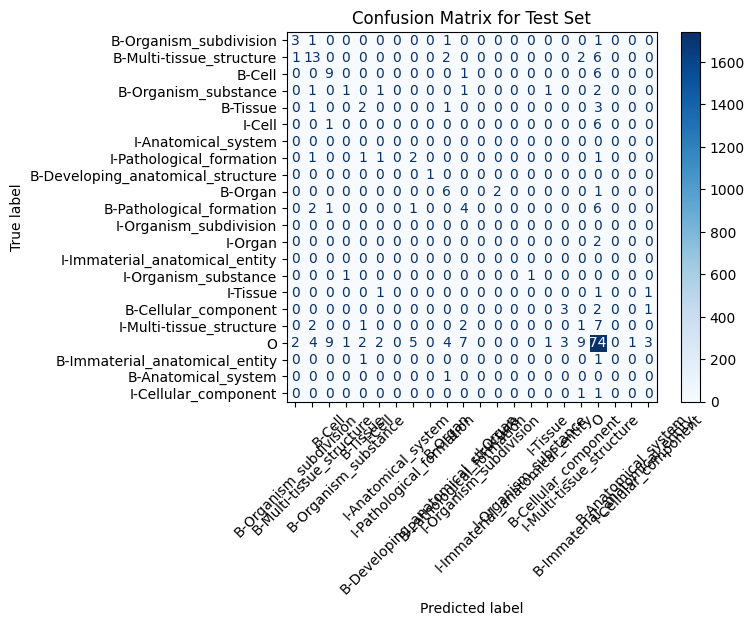

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Funzione per calcolare le predizioni e le etichette vere
def get_predictions_and_labels(trainer, dataset):
    # Ottieni predizioni dal modello
    predictions, labels, _ = trainer.predict(dataset)

    # Convertire le predizioni probabilistiche in etichette
    predictions = np.argmax(predictions, axis=2)

    # Filtra i token speciali (-100) dalle etichette
    true_labels = [
        [label for label in label_seq if label != -100]
        for label_seq in labels
    ]
    pred_labels = [
        [pred for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    # Appiattire le liste per calcolare la matrice di confusione
    true_labels = [item for sublist in true_labels for item in sublist]
    pred_labels = [item for sublist in pred_labels for item in sublist]

    return true_labels, pred_labels

# Etichette vere e predette dal test set
true_labels, pred_labels = get_predictions_and_labels(trainer_fine_tuned, tokenized_datasets['test'])
# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(tag2id.values()))

# Mappare gli ID delle etichette ai nomi dei tag NER
labels = [id2tag[id_] for id_ in tag2id.values()]
# Visualizzare la matrice di confusione
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Test Set")
plt.show()


In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

# Specificare la directory dove sono salvati i file
model_directory = "/content/drive/MyDrive/Assignment/fine_tuned_model"

# Caricare il modello fine-tunato e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained(model_directory)

# Funzione di predizione
def predict_ner(sentence):
    # Tokenizzare la frase
    inputs = tokenizer.encode_plus(
        sentence,
        return_tensors='pt',             # Restituisce l'output come tensori PyTorch
        is_split_into_words=False,       # Input è una frase completa
        truncation=True,
        max_length=128                   # Lunghezza max usata durante l'addestramento
    )
    input_ids = inputs['input_ids']

    model.eval()  # Metti il modello in modalità valutazione per evitare modifiche ai pesi

    # Ottenere le predizioni
    with torch.no_grad():
        outputs = model(**inputs)  # Ottieni i logits
        predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()  # Per ogni token seleziona la classe con la probabilità più alta

    # Convertire input_ids in token
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Ricostruire le parole dai sub-token e assegnare le etichette
    words = []
    labels = []
    for idx, (token, pred) in enumerate(zip(tokens, predictions)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue
        if token.startswith('##'):
            words[-1] += token[2:]  # Combina sub-token
        else:
            words.append(token)
            labels.append(id2tag[pred])  # Mappa l'indice della classe con il tag

    # Stampare le parole e le relative etichette
    print("\nPredizione:")
    print("Parola\tEtichetta")
    for word, label in zip(words, labels):
        print(f"{word}\t{label}")


# Test della funzione di predizione
print("\nEsempio di predizione:")
test_sentence_1 = "The patient has a history of diabetes and heart disease."
test_sentence_2 = "MRI scan showed abnormalities in the brain."
predict_ner(test_sentence_1)
predict_ner(test_sentence_2)



Esempio di predizione:

Predizione:
Parola	Etichetta
the	O
patient	O
has	O
a	O
history	O
of	O
diabetes	O
and	O
heart	O
disease	O
.	O

Predizione:
Parola	Etichetta
mri	O
scan	O
showed	O
abnormalities	O
in	B-Organ
the	B-Organ
brain	B-Organ
.	O


In [ ]:

from transformers import AutoModelForTokenClassification, AutoTokenizer

# Percorso corretto
save_directory = '/content/drive/MyDrive/saved_model'

# Carica il modello e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(save_directory, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(save_directory, local_files_only=True)

print("Modello e tokenizer caricati con successo!")



Modello e tokenizer caricati con successo!
